In [56]:
#import usual suspects
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import hashlib

np.random.seed(42) # to make this notebook's output stable across runs

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline


## Data exploration
First, import the data, look at summary statistics, make histograms and scatter plots, and calculate correlations

In [57]:
# explore the data - graphs
housing = pd.read_csv('housing.csv')
print(housing.head())
print(housing.info())
print(housing.describe())
housing["ocean_proximity"].value_counts()


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

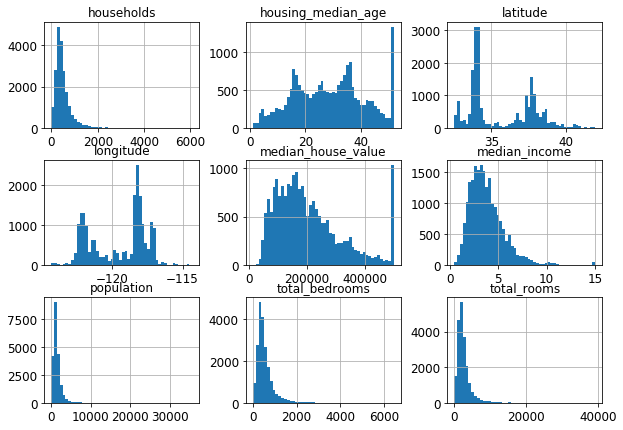

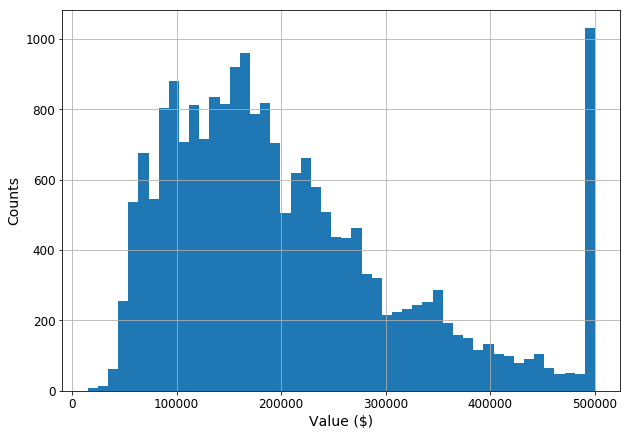

In [58]:
# ocean proximity is a cathegorical variable (5 levels)
# not sure about the unit of median income, seem low. something to doublecheck with the client
# households and population seem high, but i guess possible if there were many skyescrapers

# the rest seems fine so far, let's look at some graphs!

housing.hist(bins=50, figsize=(10,7))
plt.show()
housing["median_house_value"].hist(bins=50, figsize=(10,7))
plt.xlabel('Value ($)')
plt.ylabel('Counts')
plt.show()


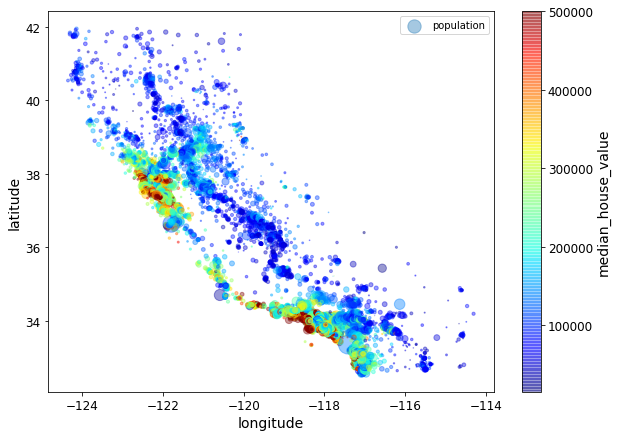

In [59]:
# interestingly, it seems all houses woth more than 500.000$ are registred as worth exactly 500.000$

# let's also look at the geoghraphical location
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    label="population", figsize=(10,7), s=housing["population"]/100, 
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.savefig('map.png')
plt.show()


In [60]:
# let's now explore which attributes correlates with the mediam price, which is the quantity we would like to be able to predict
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

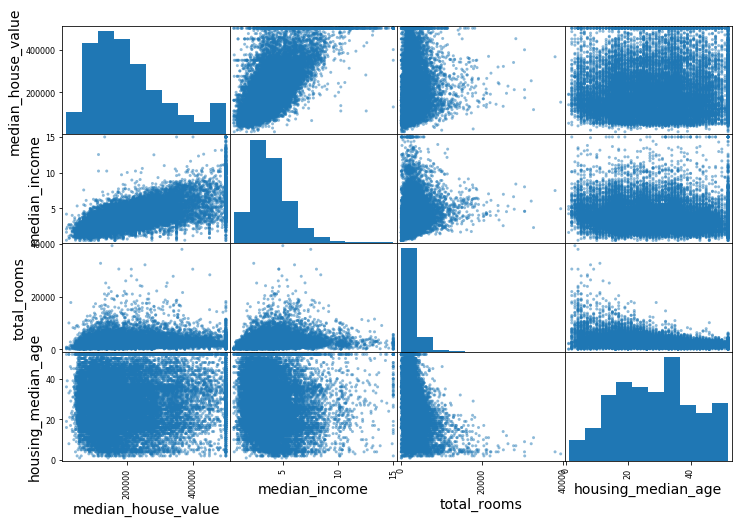

In [61]:
# now let's plot scatterplots for the attributes that appear more informative
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

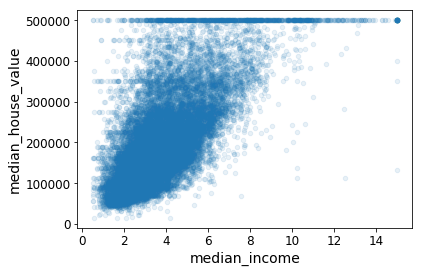

In [62]:
# as it appeared from the correlation analysis already, the most informative attribute is by fare the median income of the inhabitant
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.show()

In [63]:
# however, we might gain more insight if we could come up with meaningful features
housing["rooms_per_household"]      = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]        = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# let's see...
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [64]:
# indeed, rooms/household and bedrooms/room seems informative!
# good job at engineering features ;)


## Data preparation
After exploring, we can now think about how to prepare the data so that a model has good chances to perform well


In [65]:
# one way to handle categorical features is to create, for each category, a binary feature (sometimes called dummy_variables) 
# this means turning the N levels of the feature "ocean proximity" (inland,island) into N new features

# first, encode the category
housing_cat_encoded, housing_categories = housing['ocean_proximity'].factorize()

# then use the class OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
# note that fit_transform expects 2D arrays, but housing_cat_encoded is 1D, so reshape (-1 means infer the correct size)

# note, soon there will be in scikit-learn a CategoricalEncoder class that will further simplify the process

note that The OneHotEncoder returns a sparse array by default, but we can convert it to a dense array if needed:
housing_cat_1hot.toarray()

In [66]:
# now let's address the missing values - replace with the mean (other options: discard datapoint, discard feature)
# first let's consider numerical features 
housing_num = housing.drop('ocean_proximity', axis = 1)
housing_num = housing_num.fillna(housing_num.median())

# often scaling the features helps the machine learning algorithm (eg gradient descent performs better, clustering will not depend on measurement units, ecc)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
housing_num_scaled = scaler.fit_transform(housing_num)


In [67]:
housing_cat = pd.DataFrame(housing_cat_1hot.toarray(), columns = housing_categories)
housing_ready = pd.concat([housing_num, housing_cat], axis = 1)


In [70]:
# Now, split dataset in training set (used to identify the parameters of the model) and test set(used to validate the model on new data points)
# setting the random state ensure the same test and training sets are selected every time, 
# but only if the dataset does not change!
# or if new eventual data points are added to the dataset at the bottom
train_set, test_set = train_test_split(housing_ready, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


This way of splitting the dataset is widely used, but has the potential downside that chances are higher to sample around the median
This is not necessarily bad, but you might want to ensure that more distant values are also represented 

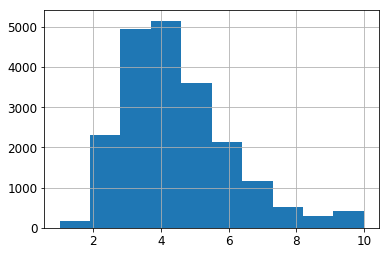

4.0     0.249516
3.0     0.239583
5.0     0.174176
2.0     0.111434
6.0     0.102955
7.0     0.056444
8.0     0.024709
10.0    0.019622
9.0     0.013808
1.0     0.007752
Name: income_cat, dtype: float64
4.0     0.249516
3.0     0.239632
5.0     0.174322
2.0     0.111337
6.0     0.103052
7.0     0.056347
8.0     0.024661
10.0    0.019719
9.0     0.013711
1.0     0.007703
Name: income_cat, dtype: float64


In [71]:
housing_ready["income_cat"] = np.ceil(housing_ready["median_income"])
housing_ready["income_cat"].where(housing_ready["income_cat"] < 10, 10.0, inplace=True) # Label those above 5 as 5
housing_ready["income_cat"].hist()
plt.show()

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_ready, housing_ready["income_cat"]):
    strat_train_set = housing_ready.loc[train_index]
    strat_test_set = housing_ready.loc[test_index]

# now check that ratios are respected
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
print(housing_ready["income_cat"].value_counts() / len(housing_ready))


As we can see, ratios in the training dataset are very similar to those in the housing dataset, so every cathegory is well represented 

## Select and train the model

In [73]:
X_train = strat_train_set.drop("median_house_value", axis = 1)
Y_train = strat_train_set["median_house_value"]

In [77]:
# let's start with something simple: how good can we do with linear regression?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

# NB: cross validation expects a utility function (great is better) so for our goal (minimze error) we will pas the negative mse
scores = cross_val_score(lin_reg, X_train, Y_train, scoring="neg_mean_squared_error", cv=10)
linReg_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(linReg_rmse_scores)


rmse error = 66799.79


it works, but performs not so great. for houses costing around 150k, being of by 68k is not great.

it seems that linear regression underfits the model, let's try something more complex

In [84]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth = 5)
scores = cross_val_score(tree_reg, X_train, Y_train, scoring="neg_mean_squared_error", cv=10)
tree_reg_rmse_scores = np.sqrt(-scores)
display_scores(tree_reg_rmse_scores)



Scores: [68722.58380088 65710.79123083 67085.23422624 67517.02035548
 70061.20976734 68999.98995866 66500.0138228  68388.60202049
 66532.77835345 69096.77244003]
Mean: 67861.49959762108
Standard deviation: 1328.3836460598438


In [85]:
# and now an ensemble method
from sklearn.ensemble import RandomForestRegressor

rnd_tree_reg = RandomForestRegressor()
scores = cross_val_score(rnd_tree_reg, X_train, Y_train, scoring="neg_mean_squared_error", cv=10)
rnd_tree_reg_rmse_scores = np.sqrt(-scores)
display_scores(rnd_tree_reg_rmse_scores)

Scores: [55278.78086998 51135.69465779 51210.52763483 50399.41144265
 53768.73758437 52068.82708153 52758.67393066 52564.70726331
 54416.90946069 52258.5529655 ]
Mean: 52586.08228912889
Standard deviation: 1455.4588547898718


# Final considerations
Ok, here we are doing a little better, but still high error! 

this model is not complete, but is a good overview of an end-to-end project, and could serve as a template.

Next steps should be:
    
- evaluate more models (eg NN, SVM with different kernels, ...)
    
- regularize the models

- fine tune the models (grid search, randomized search, bayesian optimization, ...)

- consider collecting more data 

- eventually, try the best model on the test set and check that it still performs well